# Benin_eda.ipynb

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from windrose import WindroseAxes
import plotly.express as px

In [85]:
df = pd.read_csv(
    "../data/benin.csv",
    dtype=str,
    encoding='ISO-8859-1',
    low_memory=False
)

print(df.head())

          Timestamp   GHI   DNI   DHI  ModA  ModB  Tamb    RH   WS WSgust  \
0  yyyy-mm-dd hh:mm  W/m²  W/m²  W/m²  W/m²  W/m²    °C     %  m/s    m/s   
1  2021-08-09 00:01  -1.2  -0.2  -1.1     0     0  26.2  93.4    0    0.4   
2  2021-08-09 00:02  -1.1  -0.2  -1.1     0     0  26.2  93.6    0      0   
3  2021-08-09 00:03  -1.1  -0.2  -1.1     0     0  26.2  93.7  0.3    1.1   
4  2021-08-09 00:04  -1.1  -0.1    -1     0     0  26.2  93.3  0.2    0.7   

  WSstdev            WD WDstdev   BP Cleaning Precipitation TModA TModB  \
0     m/s  °N (to east)       °  hPa   1 or 0        mm/min    °C    °C   
1     0.1         122.1       0  998        0             0  26.3  26.2   
2       0             0       0  998        0             0  26.3  26.2   
3     0.5         124.6     1.5  997        0             0  26.4  26.2   
4     0.4         120.3     1.3  997        0             0  26.4  26.3   

  Comments  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  


In [88]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format="%Y-%m-%d %H:%M")


In [89]:
df.describe()
df.isna().sum()

missing_report = df.isna().mean() * 100
missing_report[missing_report > 5]

Comments    100.0
dtype: float64

In [90]:
cols_to_check = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']
for col in cols_to_check:
    df[col] = pd.to_numeric(df[col], errors='coerce')

missing_summary = df[cols_to_check].isnull().sum()

z_scores = df[cols_to_check].apply(zscore)

outliers = (np.abs(z_scores) > 3)

outlier_counts = outliers.sum()

df[cols_to_check] = df[cols_to_check].mask(outliers)

for col in cols_to_check:
    median_value = df[col].median()
    df[col] = df[col].fillna(median_value)

output_path = "../data/benin_clean.csv"
df.to_csv(output_path, index=False)

In [91]:
print(df.shape)
print(df.head())


(525601, 19)
            Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0                 NaT  1.8 -0.1  1.6   4.5   4.3    °C     %  1.9     2.6   
1 2021-08-09 00:01:00 -1.2 -0.2 -1.1   0.0   0.0  26.2  93.4  0.0     0.4   
2 2021-08-09 00:02:00 -1.1 -0.2 -1.1   0.0   0.0  26.2  93.6  0.0     0.0   
3 2021-08-09 00:03:00 -1.1 -0.2 -1.1   0.0   0.0  26.2  93.7  0.3     1.1   
4 2021-08-09 00:04:00 -1.1 -0.1 -1.0   0.0   0.0  26.2  93.3  0.2     0.7   

  WSstdev            WD WDstdev   BP Cleaning Precipitation TModA TModB  \
0     m/s  °N (to east)       °  hPa   1 or 0        mm/min    °C    °C   
1     0.1         122.1       0  998        0             0  26.3  26.2   
2       0             0       0  998        0             0  26.3  26.2   
3     0.5         124.6     1.5  997        0             0  26.4  26.2   
4     0.4         120.3     1.3  997        0             0  26.4  26.3   

  Comments  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      N

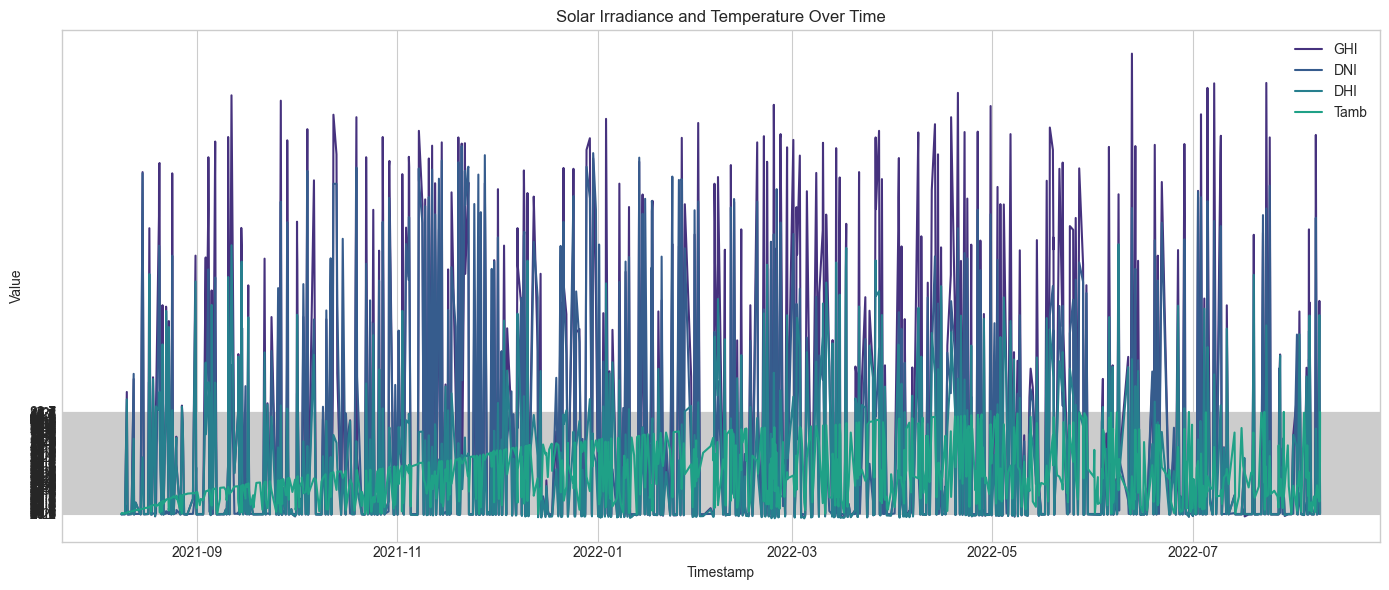

In [92]:
df["Month"] = df["Timestamp"].dt.month
df["Hour"] = df["Timestamp"].dt.hour

plt.figure(figsize=(14, 6))
sample_df = df.sample(1000).sort_values('Timestamp')  # Sample for better visibility
for col in ['GHI', 'DNI', 'DHI', 'Tamb']:
    plt.plot(sample_df['Timestamp'], sample_df[col], label=col)

plt.title("Solar Irradiance and Temperature Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()

In [95]:
df['Tamb'] = pd.to_numeric(df['Tamb'], errors='coerce')

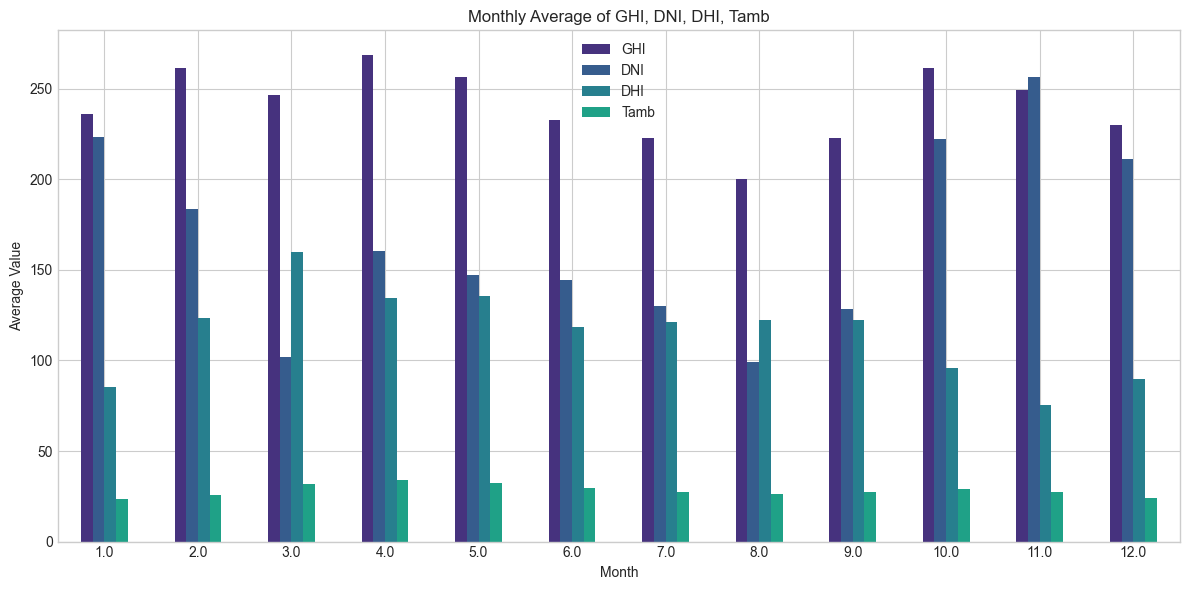

In [96]:
monthly_avg = df.groupby("Month")[["GHI", "DNI", "DHI", "Tamb"]].mean()

monthly_avg.plot(kind='bar', figsize=(12, 6))
plt.title("Monthly Average of GHI, DNI, DHI, Tamb")
plt.xlabel("Month")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


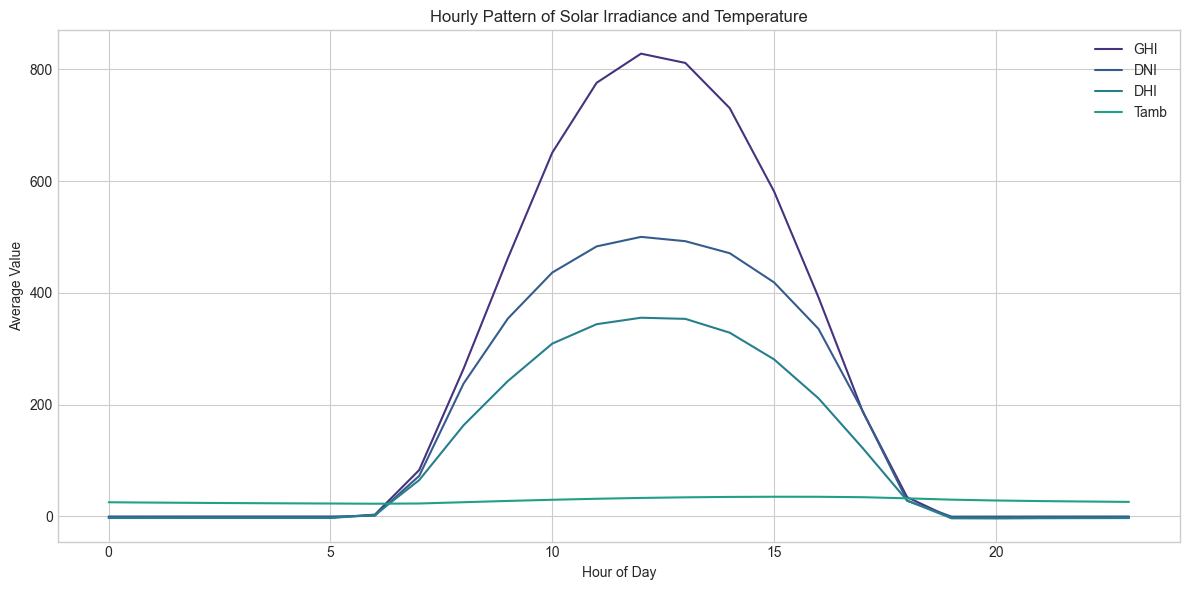

In [97]:
hourly_avg = df.groupby("Hour")[["GHI", "DNI", "DHI", "Tamb"]].mean()

hourly_avg.plot(figsize=(12, 6))
plt.title("Hourly Pattern of Solar Irradiance and Temperature")
plt.xlabel("Hour of Day")
plt.ylabel("Average Value")
plt.grid(True)
plt.tight_layout()
plt.show()


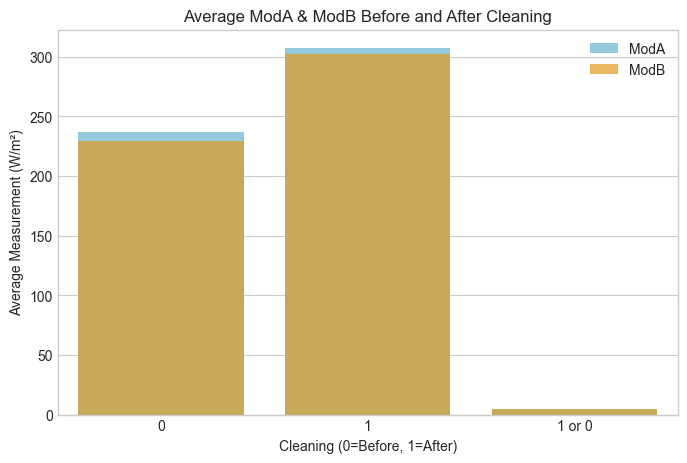

In [98]:
df['ModA'] = pd.to_numeric(df['ModA'], errors='coerce')
df['ModB'] = pd.to_numeric(df['ModB'], errors='coerce')

df_clean = df.dropna(subset=['ModA', 'ModB'])

cleaning_group = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(x='Cleaning', y='ModA', data=cleaning_group, color='skyblue', label='ModA')
sns.barplot(x='Cleaning', y='ModB', data=cleaning_group, color='orange', alpha=0.7, label='ModB')

plt.title('Average ModA & ModB Before and After Cleaning')
plt.xlabel('Cleaning (0=Before, 1=After)')
plt.ylabel('Average Measurement (W/m²)')
plt.legend()
plt.show()


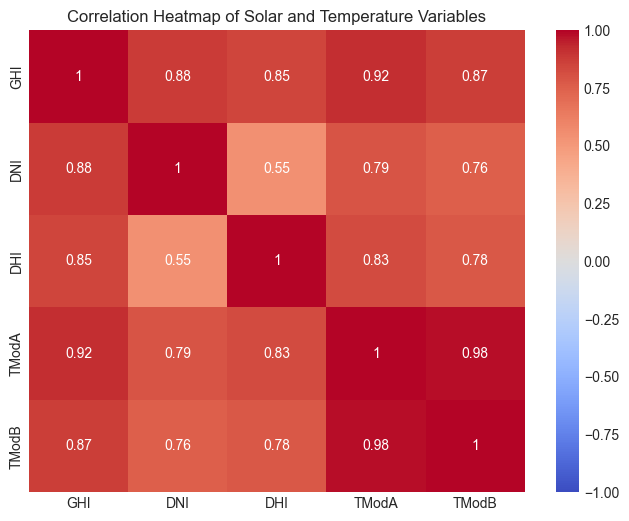

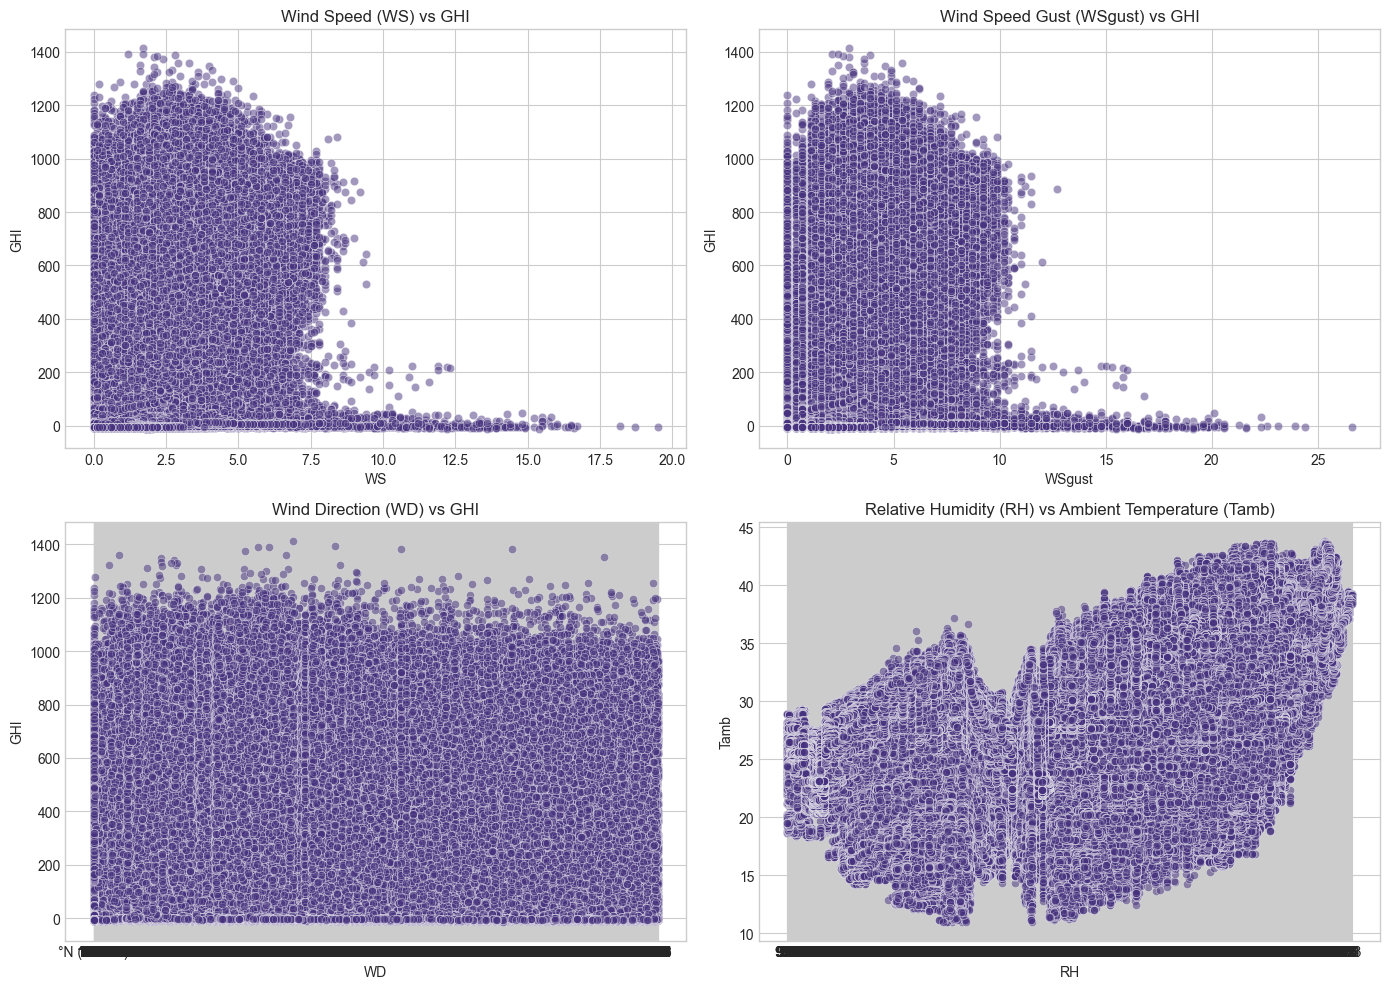

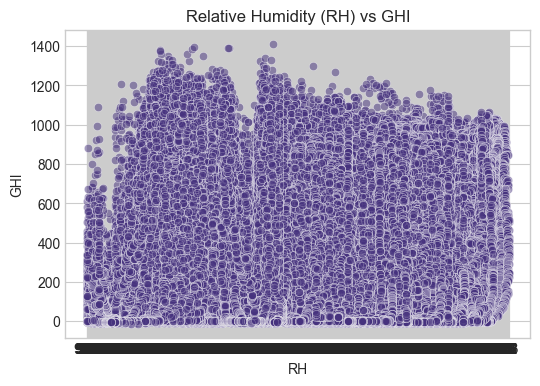

In [99]:
cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Correlation heatmap
plt.figure(figsize=(8,6))
corr = df[cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Solar and Temperature Variables')
plt.show()

# Scatter plots
fig, axs = plt.subplots(2, 2, figsize=(14,10))

# WS vs GHI
sns.scatterplot(data=df, x='WS', y='GHI', ax=axs[0,0], alpha=0.5)
axs[0,0].set_title('Wind Speed (WS) vs GHI')

# WSgust vs GHI
sns.scatterplot(data=df, x='WSgust', y='GHI', ax=axs[0,1], alpha=0.5)
axs[0,1].set_title('Wind Speed Gust (WSgust) vs GHI')

# WD (Wind Direction) vs GHI
sns.scatterplot(data=df, x='WD', y='GHI', ax=axs[1,0], alpha=0.5)
axs[1,0].set_title('Wind Direction (WD) vs GHI')

# RH vs Tamb
sns.scatterplot(data=df, x='RH', y='Tamb', ax=axs[1,1], alpha=0.5)
axs[1,1].set_title('Relative Humidity (RH) vs Ambient Temperature (Tamb)')

plt.tight_layout()
plt.show()

# Optional: RH vs GHI scatter plot (if you want another)
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x='RH', y='GHI', alpha=0.5)
plt.title('Relative Humidity (RH) vs GHI')
plt.show()

<Figure size 800x800 with 0 Axes>

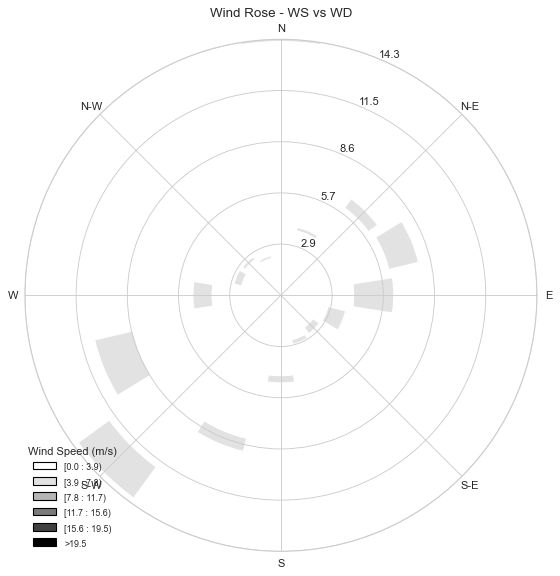

In [101]:
df['WS'] = pd.to_numeric(df['WS'], errors='coerce')
df['WD'] = pd.to_numeric(df['WD'], errors='coerce')

# Drop NaNs for windrose plot
wind_data = df.dropna(subset=['WS', 'WD'])

plt.figure(figsize=(8, 8))
ax = WindroseAxes.from_ax()
ax.bar(wind_data['WD'], wind_data['WS'], normed=True, opening=0.8, edgecolor='white')
ax.set_legend(title="Wind Speed (m/s)")
plt.title('Wind Rose - WS vs WD')
plt.show()

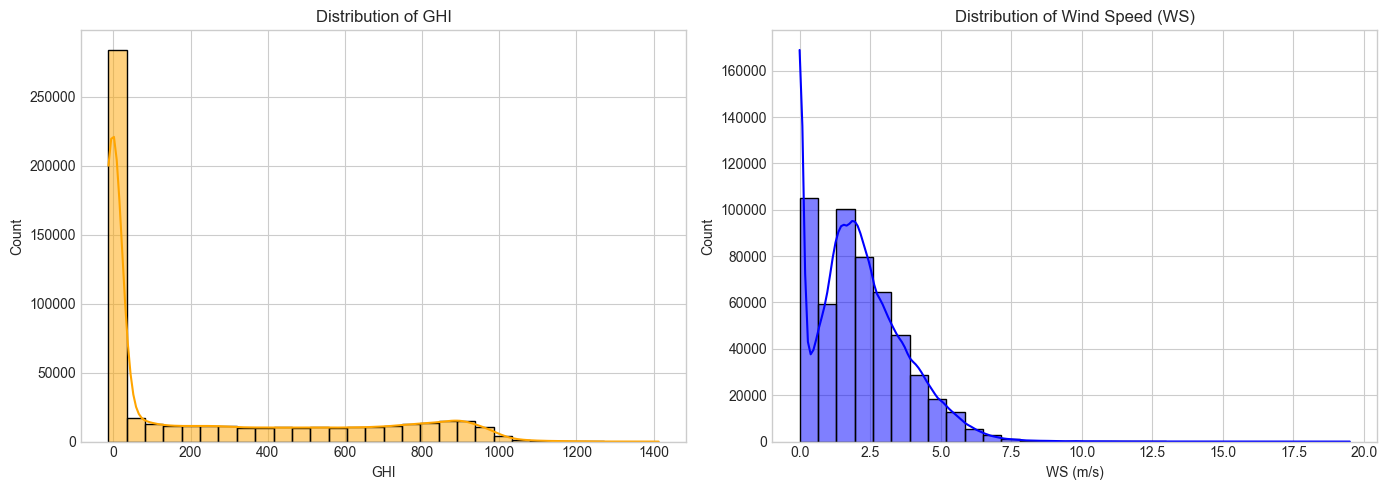

In [102]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))

# Histogram for GHI
sns.histplot(df['GHI'].dropna(), bins=30, kde=True, color='orange', ax=axs[0])
axs[0].set_title('Distribution of GHI')
axs[0].set_xlabel('GHI')

# Histogram for WS
sns.histplot(df['WS'].dropna(), bins=30, kde=True, color='blue', ax=axs[1])
axs[1].set_title('Distribution of Wind Speed (WS)')
axs[1].set_xlabel('WS (m/s)')

plt.tight_layout()
plt.show()



In [103]:
df['RH'] = pd.to_numeric(df['RH'], errors='coerce')
df['Tamb'] = pd.to_numeric(df['Tamb'], errors='coerce')
df['GHI'] = pd.to_numeric(df['GHI'], errors='coerce')
df['DNI'] = pd.to_numeric(df['DNI'], errors='coerce')
df['DHI'] = pd.to_numeric(df['DHI'], errors='coerce')


In [104]:
df_clean = df.dropna(subset=['RH', 'Tamb', 'GHI', 'DNI', 'DHI'])

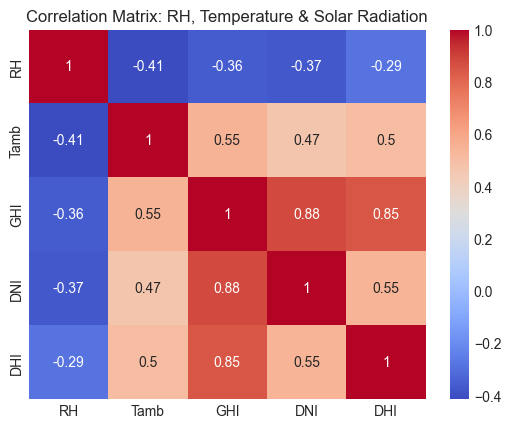

In [105]:
corr_cols = ['RH', 'Tamb', 'GHI', 'DNI', 'DHI']
corr_matrix = df_clean[corr_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix: RH, Temperature & Solar Radiation')
plt.show()

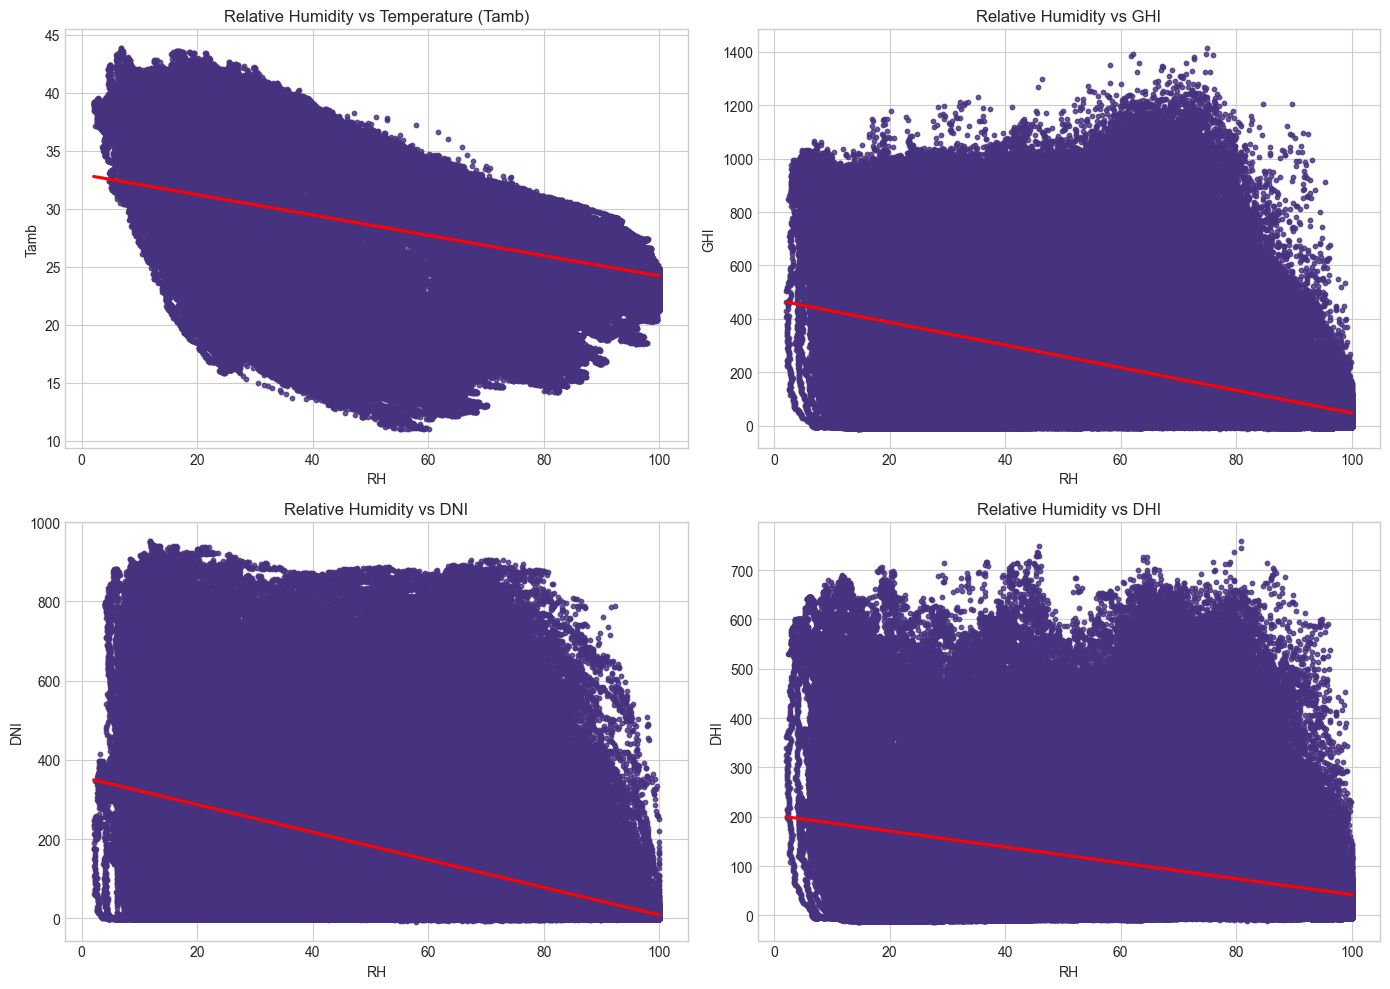

In [106]:
fig, axs = plt.subplots(2, 2, figsize=(14,10))

sns.regplot(x='RH', y='Tamb', data=df_clean, ax=axs[0,0], scatter_kws={'s':10}, line_kws={'color':'red'})
axs[0,0].set_title('Relative Humidity vs Temperature (Tamb)')

sns.regplot(x='RH', y='GHI', data=df_clean, ax=axs[0,1], scatter_kws={'s':10}, line_kws={'color':'red'})
axs[0,1].set_title('Relative Humidity vs GHI')

sns.regplot(x='RH', y='DNI', data=df_clean, ax=axs[1,0], scatter_kws={'s':10}, line_kws={'color':'red'})
axs[1,0].set_title('Relative Humidity vs DNI')

sns.regplot(x='RH', y='DHI', data=df_clean, ax=axs[1,1], scatter_kws={'s':10}, line_kws={'color':'red'})
axs[1,1].set_title('Relative Humidity vs DHI')

plt.tight_layout()
plt.show()


In [107]:
bins = [0, 30, 60, 100]
labels = ['Low', 'Medium', 'High']
df_clean['RH_Level'] = pd.cut(df_clean['RH'], bins=bins, labels=labels)

avg_by_rh = df_clean.groupby('RH_Level')[['Tamb', 'GHI', 'DNI', 'DHI']].mean().reset_index()
print(avg_by_rh)


C:\Users\Bisrat\AppData\Local\Temp\ipykernel_8020\993312455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['RH_Level'] = pd.cut(df_clean['RH'], bins=bins, labels=labels)
C:\Users\Bisrat\AppData\Local\Temp\ipykernel_8020\993312455.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_rh = df_clean.groupby('RH_Level')[['Tamb', 'GHI', 'DNI', 'DHI']].mean().reset_index()


  RH_Level       Tamb         GHI         DNI         DHI
0      Low  31.302793  384.767974  293.175833  170.263280
1   Medium  28.616729  256.643298  181.526105  112.911943
2     High  26.082292  146.305301   84.660500   84.896772


In [108]:
df_bubble = df[['GHI', 'Tamb', 'RH', 'BP']].copy()
df_bubble = df_bubble.dropna()

fig = px.scatter(
    df_bubble,
    x='Tamb',
    y='GHI',
    size='RH',            
    color='RH',          
    hover_data=['BP'],    
    labels={
        'Tamb': 'Temperature (°C)',
        'GHI': 'Global Horizontal Irradiance (W/m²)',
        'RH': 'Relative Humidity (%)',
        'BP': 'Barometric Pressure (hPa)'
    },
    title='Bubble Chart: GHI vs Temperature with Bubble Size = RH'
)

fig.update_layout(
    xaxis=dict(title='Temperature (Tamb, °C)'),
    yaxis=dict(title='Global Horizontal Irradiance (GHI, W/m²)'),
    legend_title='Relative Humidity',
    template='plotly_white'
)

fig.show()


ModuleNotFoundError: No module named 'plotly'